In [37]:
import json
import re
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from collections import Counter
from nltk import bigrams
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns


# Data Preprocessing

In [ ]:
with open("datasets/putin_complete.json", "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data)

print("HEAD (raw):")
print(df.head(2))
print("\nNumber of rows:", len(df))
print("Columns:", df.columns.tolist())

text_cols = ["transcript_unfiltered", "transcript_filtered"]

for col in text_cols:
    if col in df.columns:
        df[col] = df[col].fillna("").astype(str)

df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df[df["date"].notna()].reset_index(drop=True)

putin_mask = df["transcript_unfiltered"].str.contains(r"\bPutin\b\s*:", regex=True, na=False)
df = df[putin_mask].reset_index(drop=True)

df["transcript_unfiltered"] = df["transcript_unfiltered"].str.replace(
    r"^.*\bPutin\b\s*:\s*", "", regex=True
)

df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

df["text_raw"] = df["transcript_filtered"].where(
    df["transcript_filtered"].str.len() > 0,
    df["transcript_unfiltered"]
)

df["sentences"] = df["text_raw"].apply(
    lambda x: re.split(r"(?<=[.!?])\s+", x.strip()) if x.strip() else []
)

df["sentence_count"] = df["sentences"].apply(len)

def ensure_wordlist(row):
    wl = row.get("wordlist", None)
    if not isinstance(wl, list) or len(wl) == 0:
        return word_tokenize(row["text_raw"])
    return wl

df["tokens_full"] = df.apply(ensure_wordlist, axis=1)

def clean_tokens(tokens):
    return [t.lower() for t in tokens if t.strip() != ""]

df["tokens_clean"] = df["tokens_full"].apply(clean_tokens)

def keep_alpha_tokens(tokens):
    return [t for t in tokens if re.fullmatch(r"[a-z]+", t)]

df["tokens_lexical"] = df["tokens_clean"].apply(keep_alpha_tokens)

stop_words = set(stopwords.words("english"))

df["tokens_nostop"] = df["tokens_lexical"].apply(
    lambda x: [t for t in x if t not in stop_words]
)

lemmatizer = WordNetLemmatizer()

df["tokens_lemma"] = df["tokens_nostop"].apply(
    lambda toks: [lemmatizer.lemmatize(t) for t in toks]
)

df["token_count"] = df["tokens_lexical"].apply(len)
df["unique_tokens"] = df["tokens_lexical"].apply(lambda x: len(set(x)))

df["lexical_diversity"] = df.apply(
    lambda r: r["unique_tokens"] / r["token_count"] if r["token_count"] > 0 else 0,
    axis=1
)

df["avg_sentence_length"] = df.apply(
    lambda r: r["token_count"] / r["sentence_count"] if r["sentence_count"] > 0 else 0,
    axis=1
)

def rhetorical_features(text):
    return {
        "exclamation_count": text.count("!"),
        "question_count": text.count("?"),
        "ellipsis_count": text.count("...")
    }

rhet_feats = df["text_raw"].apply(rhetorical_features)
rhet_df = pd.DataFrame(list(rhet_feats))
df = pd.concat([df, rhet_df], axis=1)

HEAD (raw):
                  date persons  \
0  1999-12-31T00:01:00      []   
1  1999-12-31T00:02:00      []   

                               transcript_unfiltered  kremlin_id  \
0  Vladimir Putin: Dear friends, On New Year’s Ev...     22280.0   
1  Vladimir Putin: Good afternoon, distinguished ...     22326.0   

                 place                                              title  \
0  The Kremlin, Moscow  New Year Address by Acting President Vladimir ...   
1  The Kremlin, Moscow  Address at an expanded meeting of the Russian ...   

  teaser tags                                transcript_filtered  \
0          []  Dear friends, On New Year’s Eve, my family and...   
1          []  Good afternoon, distinguished colleagues. This...   

                                            wordlist  
0  [dear, friend, ,, on, New, Year, ’s, Eve, ,, m...  
1  [good, afternoon, ,, distinguished, colleague,...  

Number of rows: 9838
Columns: ['date', 'persons', 'transcript_unfiltered', 'k

In [4]:
df.to_json(
    "datasets/putin_complete_cleaned.json",
    orient="records",
    force_ascii=False,
    indent=2
)

print("\nSaved cleaned dataset: putin_complete_cleaned.json")


Saved cleaned dataset: putin_complete_cleaned.json


# EDA

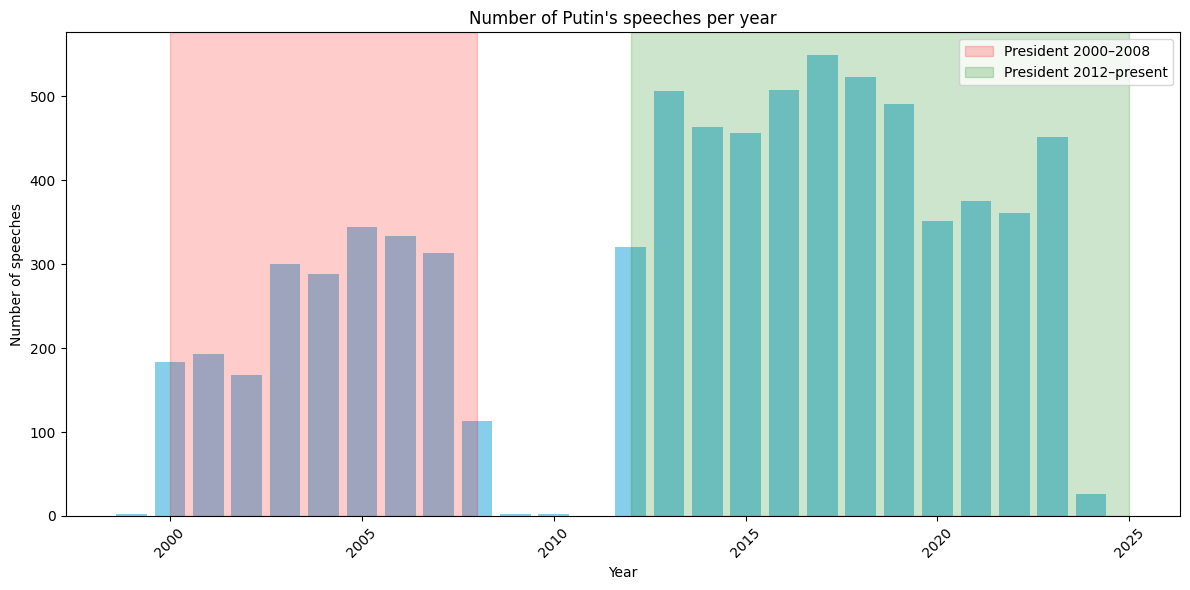

In [13]:
speeches_per_year = df["year"].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.bar(speeches_per_year.index, speeches_per_year.values, color="skyblue")
plt.xlabel("Year")
plt.ylabel("Number of speeches")
plt.title("Number of Putin's speeches per year")
plt.xticks(rotation=45)

plt.axvspan(2000, 2008, color='red', alpha=0.2, label="President 2000–2008")
plt.axvspan(2012, 2025, color='green', alpha=0.2, label="President 2012–present")

plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# filter weak words
weak_words = {"would", "like", "say", "note", "also", "one", "know", "good", "make", "take", "need", "must", "today"}

# all bograms from tokens without stopwords
all_bigrams = [bg for tokens in df["tokens_nostop"] for bg in bigrams(tokens)]

# filter bigrams without weak words
filtered_bigrams = [bg for bg in all_bigrams if bg[0] not in weak_words and bg[1] not in weak_words]

top_bigrams = Counter(filtered_bigrams).most_common(20)

print("Top 20 most common bigrams:")
for bg, count in top_bigrams:
    print(f"{bg[0]} {bg[1]}: {count}")

Top 20 most common bigrams:
russian federation: 3271
last year: 3056
prime minister: 2936
united states: 2671
thank much: 2462
mr president: 2344
work together: 1806
st petersburg: 1727
long term: 1563
far east: 1473
soviet union: 1374
young people: 1205
law enforcement: 1189
next year: 1124
year ago: 1123
european union: 1122
bilateral relation: 1079
lady gentleman: 1073
trade economic: 1067
security council: 1051


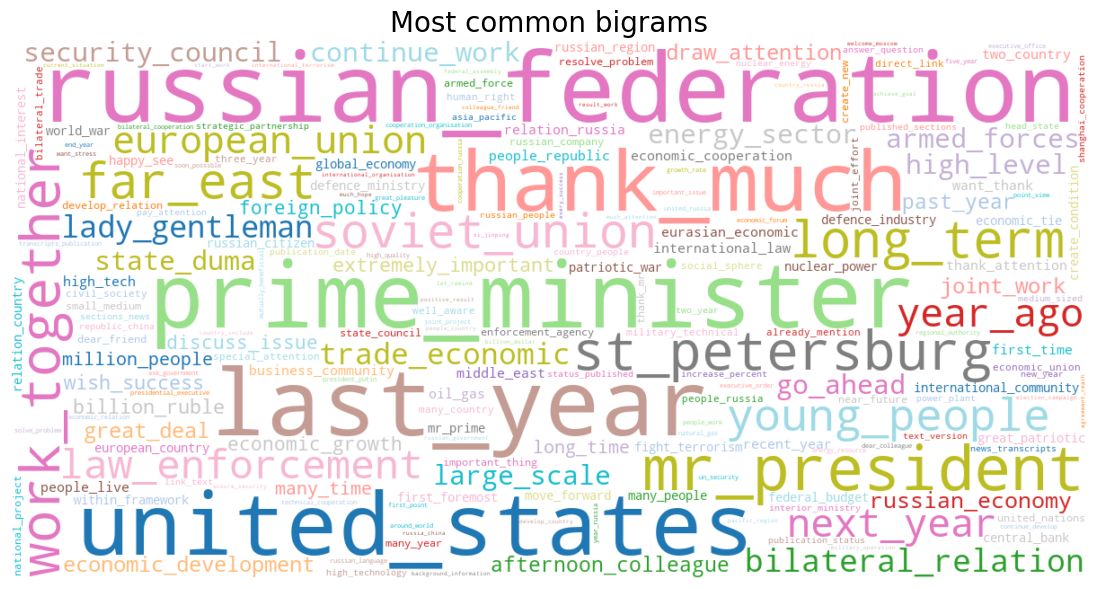

In [12]:
bigram_phrases = ["_".join(bg) for bg in filtered_bigrams]

bigram_counts = Counter(bigram_phrases)

wc = WordCloud(width=1200, height=600, background_color="white", colormap="tab20")
wc.generate_from_frequencies(bigram_counts)

plt.figure(figsize=(15, 7))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Most common bigrams", fontsize=20)
plt.show()

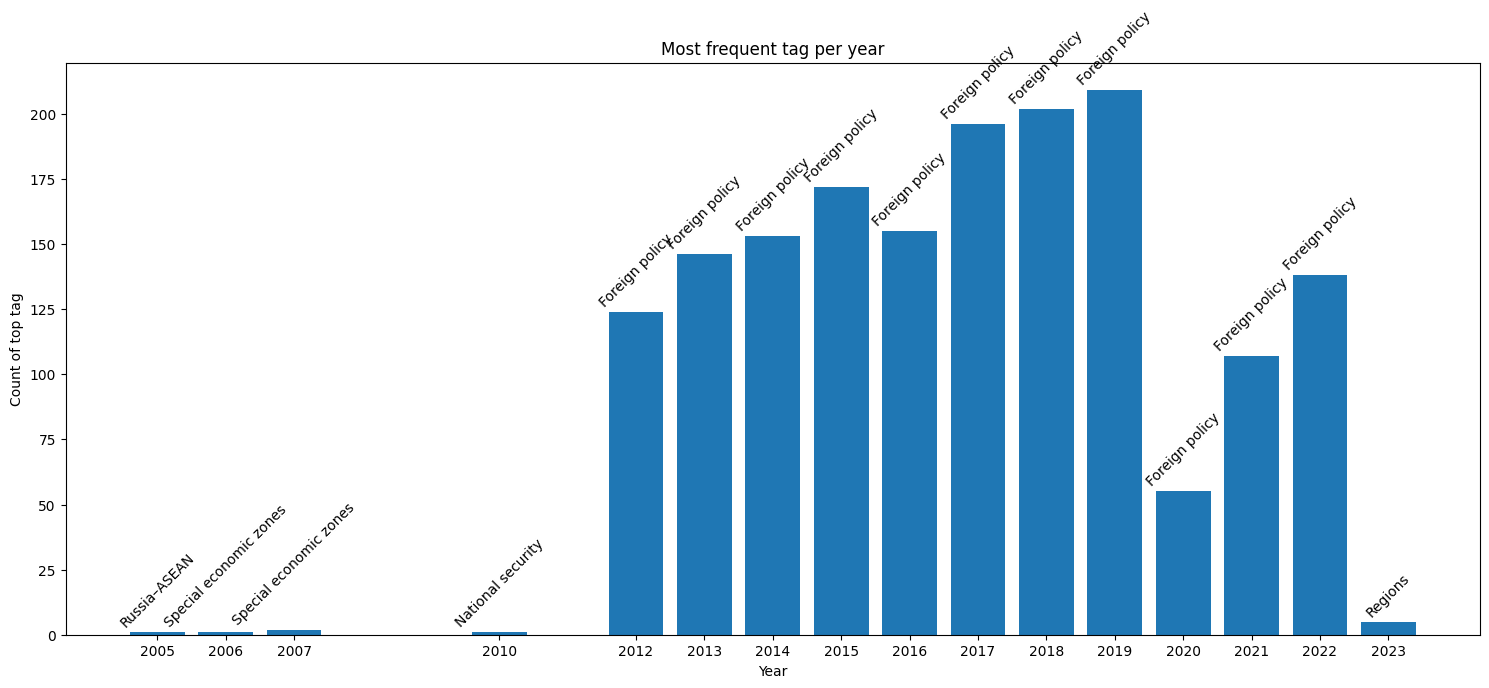

In [30]:
df_year_tag = df.explode('tags')

top_tags_per_year = {}
for year, group in df_year_tag.groupby('year'):
    tags_counter = Counter(group['tags'].dropna())
    if tags_counter:
        tag, count = tags_counter.most_common(1)[0]
        top_tags_per_year[year] = (tag, count)

years = list(top_tags_per_year.keys())
counts = [top_tags_per_year[y][1] for y in years]
tags = [top_tags_per_year[y][0] for y in years]

plt.figure(figsize=(15,7))
bars = plt.bar(years, counts)
plt.xlabel("Year")
plt.ylabel("Count of top tag")
plt.title("Most frequent tag per year")

plt.xticks(years) 
for bar, tag in zip(bars, tags):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, tag, ha='center', va='bottom', rotation=45)

plt.tight_layout()
plt.show()

In [35]:
economy_terms = [
    'growth', 'development', 'market', 'investment', 'industry', 
    'tax', 'budget', 'finance', 'trade', 'commerce', 'inflation', 'deficit', 'revenue', 
    'spending', 'expenditure', 'fiscal', 'monetary', 'capital', 'production', 'consumption', 
    'export', 'import', 'employment', 'unemployment', 'income', 'wealth', 'property', 
    'corporation', 'business', 'bank', 'credit', 'loan', 'interest', 'stock', 'bond', 
    'shares', 'equity', 'profit', 'loss', 'subsidy', 'tariff', 'duty', 'policy', 'regulation', 
    'privatization', 'nationalization', 'sector', 'infrastructure', 'resources', 'industrialization',

    'investment', 'venture', 'portfolio', 'fund', 'funding', 'capitalization', 'liquidity', 
    'asset', 'liability', 'balance', 'account', 'budgetary', 'deflation', 'debt', 'creditor', 
    'debtor', 'interest rate', 'inflation rate', 'monetary policy', 'fiscal policy', 'exchange rate',

    'agriculture', 'manufacturing', 'energy', 'oil', 'gas', 'mining', 'technology', 'telecom', 
    'transport', 'logistics', 'construction', 'real estate', 'tourism', 'retail', 'wholesale', 
    'service', 'industrial', 'industrialization', 'automation', 'export-oriented', 'import-substitution',

    'regulation', 'deregulation', 'subsidies', 'incentives', 'taxation', 'tariffs', 'customs', 
    'trade agreement', 'free trade', 'protectionism', 'economic policy', 'fiscal responsibility', 
    'budget deficit', 'public spending', 'government spending', 'state support', 'strategic sector',

    'gdp', 'gross domestic product', 'per capita', 'economic growth', 'macroeconomics', 'microeconomics', 
    'productivity', 'efficiency', 'competitiveness', 'innovation', 'research', 'development', 'exports', 'imports', 
    'balance of payments', 'foreign investment', 'foreign trade', 'industrial output', 'national income',

    'banking', 'central bank', 'monetary system', 'financial system', 'credit system', 'bank loan', 
    'interest rate', 'financial institution', 'reserve', 'capital market', 'money supply', 'cash flow', 
    'liquid asset', 'financial stability', 'risk management', 'hedging', 'derivatives', 'securities',

    'job', 'employment', 'workforce', 'labor', 'labor market', 'wage', 'salary', 'pension', 
    'social security', 'benefit', 'insurance', 'standard of living', 'poverty', 'economic inequality', 
    'household income', 'consumer', 'spending power', 'consumption patterns',

    'entrepreneurship', 'startup', 'business development', 'industrial policy', 'innovation hub', 
    'research and development', 'productivity growth', 'economic reform', 'economic strategy', 
    'sustainable development', 'resource management', 'energy policy', 'trade balance', 'foreign exchange', 
    'domestic market', 'global market', 'investment climate', 'business environment', 'capital formation'
]
term_counts = Counter()
for tokens in df['tokens_nostop']:
    term_counts.update([t for t in tokens if t in economy_terms])
top3_economy = term_counts.most_common(3)
print("Top 3 economy-related terms:", top3_economy)

Top 3 economy-related terms: [('development', 12962), ('interest', 7202), ('business', 7153)]


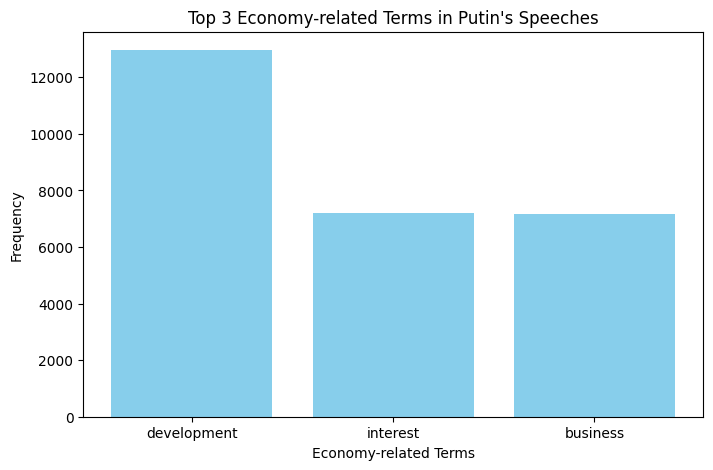

In [36]:
terms, counts = zip(*top3_economy)

plt.figure(figsize=(8,5))
plt.bar(terms, counts, color='skyblue')
plt.xlabel("Economy-related Terms")
plt.ylabel("Frequency")
plt.title("Top 3 Economy-related Terms in Putin's Speeches")
plt.show()

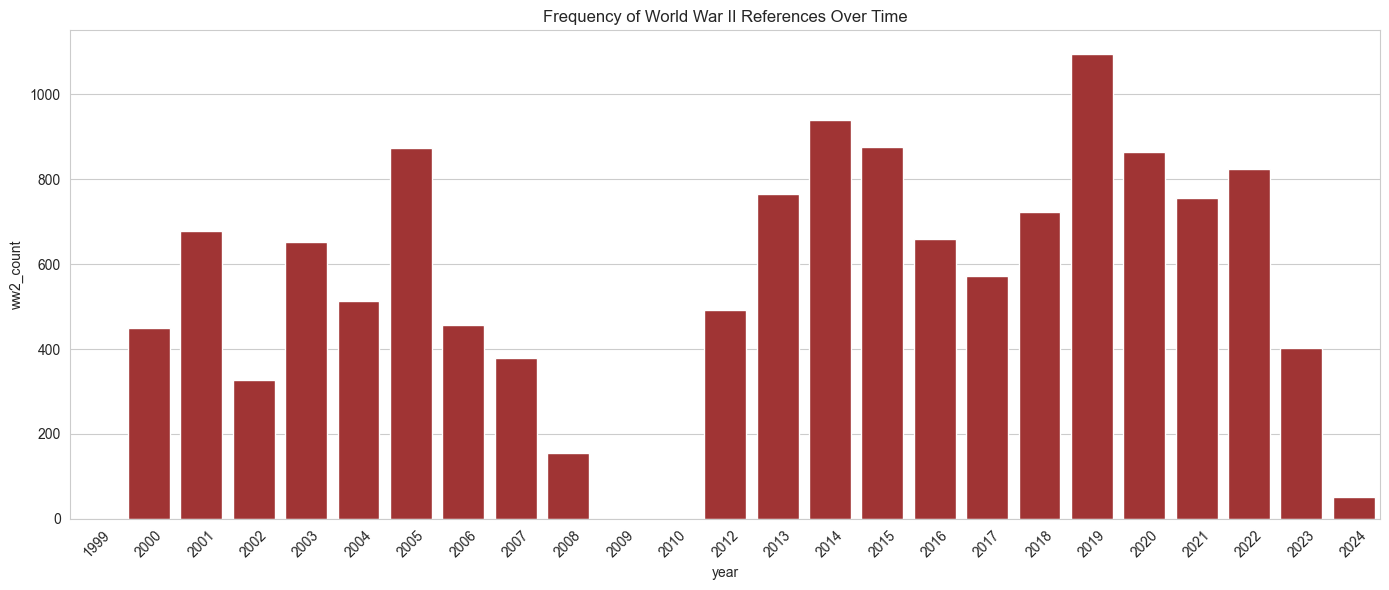

In [ ]:
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)

ww2_keywords = [
    "war", "world war ii", "wwii", "nazi", "nazism", "fascism", "fascist", 
    "great patriotic war", "victory", "veteran", "hitler", "germany", "soviet union",
    "ussr", "allies", "axis", "stalin", "churchill", "roosevelt", "mussolini",
    "blitzkrieg", "holocaust", "concentration camp", "ghetto", "occupations",
    "invasion", "battle", "front", "eastern front", "western front",
    "d-day", "normandy", "pearl harbor", "midway", "stalingrad", "kursk",
    "berlin", "hiroshima", "nagasaki", "atomic bomb", "liberation", "resistance",
    "partisan", "propaganda", "rationing", "air raid", "bombing", "naval battle",
    "submarine", "tank", "infantry", "soldier", "generals", "commander",
    "trench", "occupation", "siege", "armistice", "treaty", "munich agreement",
    "yalta", "tehran conference", "postwar", "reconstruction", "war crimes",
    "nuremberg trials", "victory day", "1941", "1945", "1939", "1939-1945"
]

def count_keywords(tokens, keywords):
    if not isinstance(tokens, list):
        return 0
    return sum(1 for token in tokens if token in keywords)

temp_stats = pd.DataFrame()
temp_stats['year'] = df['year']
temp_stats['ww2_count'] = df['tokens_lexical'].apply(lambda x: count_keywords(x, ww2_keywords))

yearly_stats = temp_stats.groupby('year')[['ww2_count']].sum().reset_index()

max_ww2_row = yearly_stats.loc[yearly_stats['ww2_count'].idxmax()]


plt.figure()
sns.barplot(data=yearly_stats, x='year', y='ww2_count', color='firebrick')
plt.title("Frequency of World War II References Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


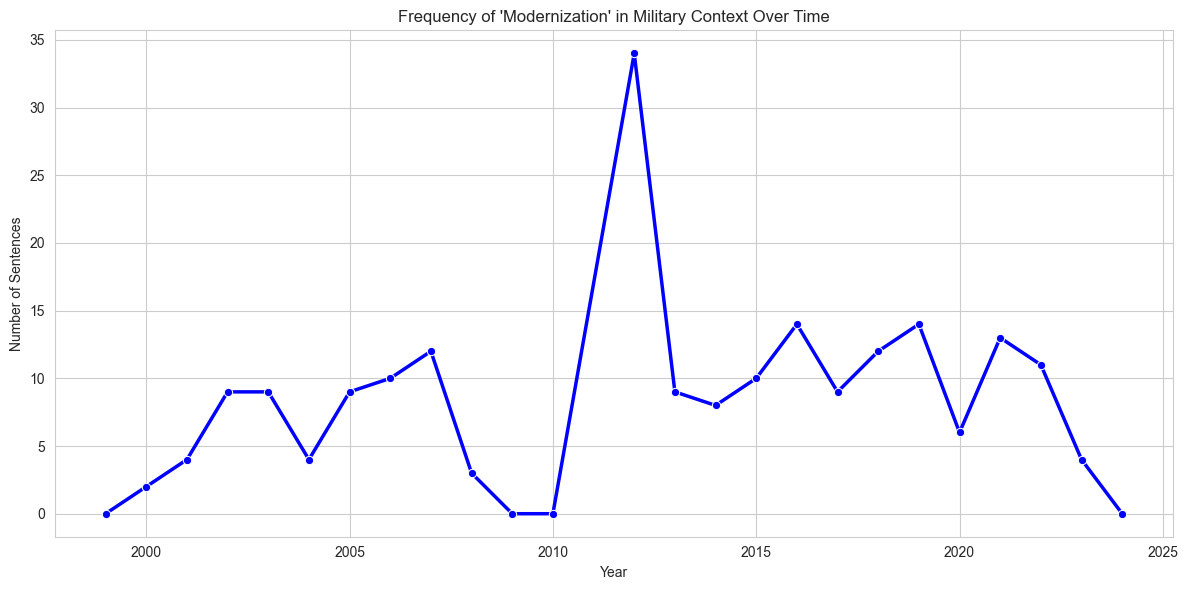

In [42]:
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

modernization_keywords = [
    "modernization", "modernisation", "modernize", "upgrade", 
    "rearm", "rearmament", "innovation", "new generation"
]

military_keywords = [
    "military", "army", "armed forces", "weapon", "defense", "defence",
    "missile", "navy", "air force", "troops", "nuclear", "combat", 
    "security", "strategic", "soldier", "fleet", "arsenal"
]

def count_military_modernization(sentences):
    if not isinstance(sentences, list):
        return 0
    count = 0
    for sent in sentences:
        words = set(re.findall(r'\w+', sent.lower()))
        
        has_modernization = any(k in words for k in modernization_keywords)
        has_military = any(k in words for k in military_keywords) or \
                       "armed forces" in sent.lower() or "air force" in sent.lower()
        
        if has_modernization and has_military:
            count += 1
    return count


mod_mil_series = df['sentences'].apply(count_military_modernization)

trend_data = pd.DataFrame({
    'year': df['year'],
    'count': mod_mil_series
}).groupby('year')['count'].sum().reset_index()

total_mentions = trend_data['count'].sum()
peak_year_row = trend_data.loc[trend_data['count'].idxmax()]

plt.figure()
sns.lineplot(
    data=trend_data, 
    x='year', 
    y='count', 
    marker='o', 
    color='blue', 
    linewidth=2.5
)
plt.title("Frequency of 'Modernization' in Military Context Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Sentences")
plt.tight_layout()
plt.show()

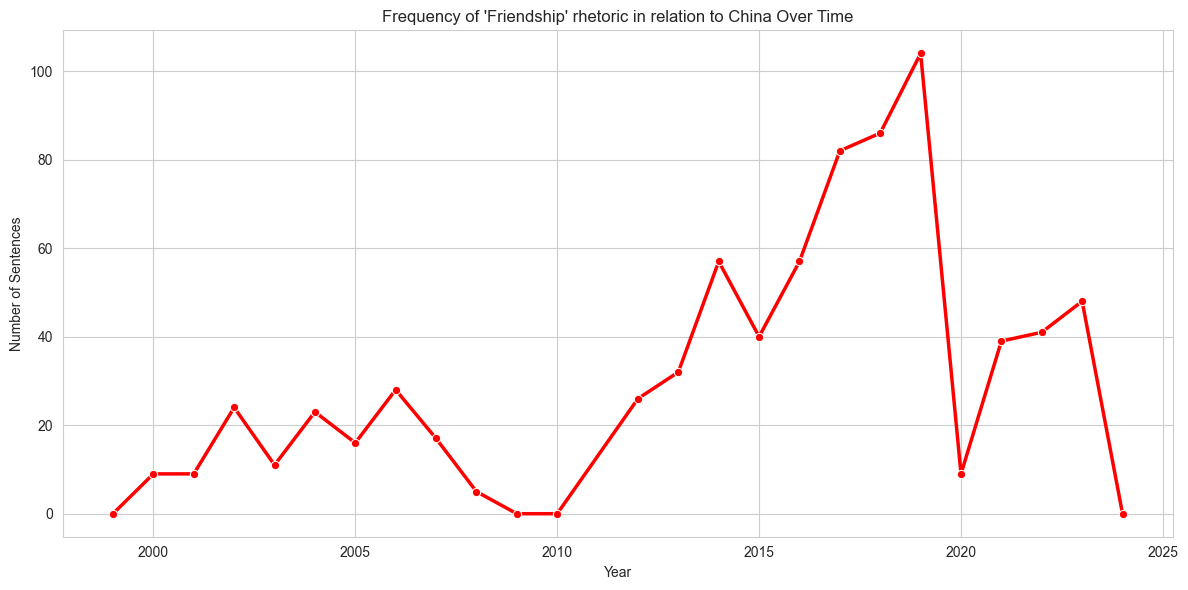

In [45]:
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

china_keywords = ["china", "chinese", "beijing", "prc"]

friendship_keywords = [
    "friend", "friendship", "friendly", "partner", "partnership", 
    "strategic", "cooperation", "ally", "allies", "bond", "close ties", "brotherly"
]

def count_china_friendship_cooccurrence(sentences):
    if not isinstance(sentences, list):
        return 0
    count = 0
    for sent in sentences:
        words = set(re.findall(r'\w+', sent.lower()))
        
        has_china = any(k in words for k in china_keywords)
        has_friendship = any(k in words for k in friendship_keywords)
        
        if has_china and has_friendship:
            count += 1
    return count


cooc_series = df['sentences'].apply(count_china_friendship_cooccurrence)

trend_data = pd.DataFrame({
    'year': df['year'],
    'count': cooc_series
}).groupby('year')['count'].sum().reset_index()

total_mentions = trend_data['count'].sum()
peak_year_row = trend_data.loc[trend_data['count'].idxmax()]

plt.figure()
sns.lineplot(
    data=trend_data, 
    x='year', 
    y='count', 
    marker='o', 
    color='red', 
    linewidth=2.5
)
plt.title("Frequency of 'Friendship' rhetoric in relation to China Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Sentences")
plt.tight_layout()
plt.show()

In [46]:
summary_data = {
    "Metric": [
        "Total Number of Speeches",
        "Total Word Count (Corpus Size)",
        "Average Speech Length (Tokens)",
        "Median Speech Length (Tokens)",
        "Average Lexical Diversity",
        "Start Year",
        "End Year"
    ],
    "Value": [
        len(df),
        df['token_count'].sum(),
        round(df['token_count'].mean(), 2),
        round(df['token_count'].median(), 2),
        round(df['lexical_diversity'].mean(), 4),
        int(df['year'].min()),
        int(df['year'].max())
    ]
}

summary_table = pd.DataFrame(summary_data)

print(summary_table.to_string(index=False))

                        Metric        Value
      Total Number of Speeches    7629.0000
Total Word Count (Corpus Size) 7026591.0000
Average Speech Length (Tokens)     921.0400
 Median Speech Length (Tokens)     475.0000
     Average Lexical Diversity       0.4739
                    Start Year    1999.0000
                      End Year    2024.0000


In [47]:
stats_data = {
    "Metric": [
        "Average Word Count (Mean)",
        "Median Word Count",
        "Minimum Word Count",
        "Maximum Word Count"
    ],
    "Value": [
        round(df['token_count'].mean(), 2),
        round(df['token_count'].median(), 2),
        df['token_count'].min(),
        df['token_count'].max()
    ]
}

stats_table = pd.DataFrame(stats_data)
print(stats_table.to_string(index=False))

                   Metric    Value
Average Word Count (Mean)   921.04
        Median Word Count   475.00
       Minimum Word Count     6.00
       Maximum Word Count 26634.00
